# [Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

In [10]:
########################################
# Load the packages
########################################
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, CuDNNGRU, Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [2]:
########################################
# Define the hyper parameters
########################################
path = 'Dataset/'
TRAIN_DATA_FILE=path + 'train.csv'
TEST_DATA_FILE=path + 'test.csv'

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300

## Prepare the training / testing data

In [3]:
########################################
# Load the training / testing set with pandas csv format
########################################
train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

## Data visualization

In [4]:
print("A quick view of training set")
train_df.head()

A quick view of training set


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
print("A quick view of testing set")
test_df.head()

A quick view of testing set


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Get positive labels

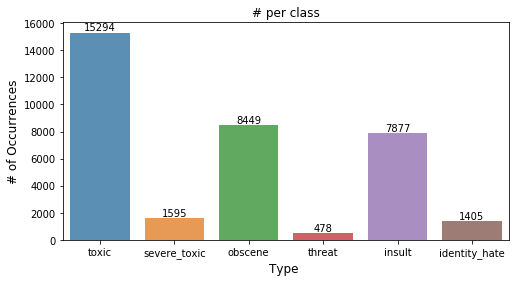

In [11]:
x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Correlations of labels

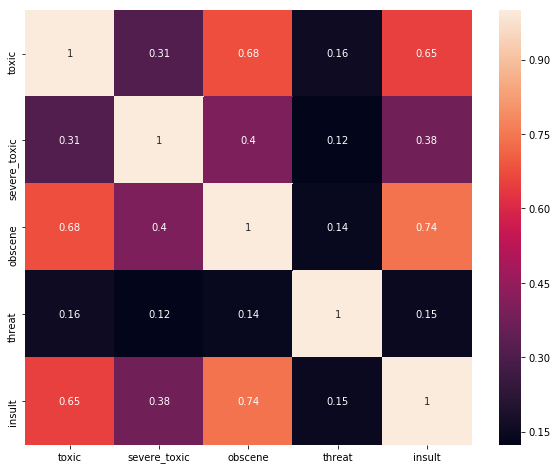

In [12]:
temp_df=train_df.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

## Preprocessing

In [6]:
########################################
## Text pre-processing and cleaning
########################################
print('Processing text dataset')
from collections import defaultdict

# regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

# regex to replace all numeric
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def clean_text(text, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    text = special_character_removal.sub('',text)

    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    return text

list_sentences_train = train_df["comment_text"].fillna("no comment").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_labels = train_df[list_classes].values
list_sentences_test = test_df["comment_text"].fillna("no comment").values

train_comments = [clean_text(text) for text in list_sentences_train]
test_comments = [clean_text(text) for text in list_sentences_test]

# Create a tokenize, which transforms a sentence to a list of ids
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

# Build the relation between words and ids 
tokenizer.fit_on_texts(train_comments + test_comments)

# Transform training/testing sentences to training/testing sequences
train_sequences = tokenizer.texts_to_sequences(train_comments)
test_sequences = tokenizer.texts_to_sequences(test_comments)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', train_labels.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor:', test_data.shape)

Processing text dataset
Found 336613 unique tokens
Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 100)


In [7]:
print("training set with word format:")
print(train_comments[:3])

training set with word format:
['explanationwhy the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now    ', 'd aww  he matches this background colour i am seemingly stuck with thanks talk  january   utc', 'hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info ']


In [8]:
print("training set with index format")
print(train_sequences[:3])

training set with index format
[[1, 133, 125, 174, 29, 679, 4231, 9277, 1127, 83, 348, 46, 83, 12, 13348, 51, 6444, 15, 60, 2499, 146, 3, 2687, 33, 110, 1171, 15522, 2502, 6, 52, 20, 12, 246, 1, 422, 31, 1, 56, 30, 138, 3, 40, 3754, 88], [349, 7779, 48, 2771, 14, 447, 3575, 3, 40, 4622, 2532, 22, 94, 56, 951, 239], [443, 365, 3, 40, 119, 12, 255, 2, 79, 308, 10, 51, 9, 14, 555, 8, 2335, 504, 481, 102, 6, 573, 2, 42, 312, 133, 361, 4, 29, 56, 30, 48, 183, 2, 437, 59, 37, 1, 2295, 91, 1, 694, 464]]


In [9]:
print("training set with padded(by zero) index format:")
print(train_data[:3])

training set with padded(by zero) index format:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     1   133   125   174
     29   679  4231  9277  1127    83   348    46    83    12 13348    51
   6444    15    60  2499   146     3  2687    33   110  1171 15522  2502
      6    52    20    12   246     1   422    31     1    56    30   138
      3    40  3754    88]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0

## Models

## Text RNN

![TextRNN](resources/textrnn.png)

Here we present a classical structure, 2 layer bidirectional GRU, for text classification. Instead of adding a fully connected layer after all time steps, here we only select the last hidden unit of sequence. (LB: 50%, AUC: 0.982)

In [10]:
########################################
## Define the text rnn model structure
########################################
def get_text_rnn():
    recurrent_units = 48
    dense_units = 32
    output_units = 6
    
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    x = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=False))(x)
    
    x = Dense(dense_units, activation="relu")(x)
    output_layer = Dense(output_units, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## TextCNN

![TextCNN](resources/textcnn.png)

Convolution in natural langauge proceessing can be consider as a special type of ngram. We simply select the kernels with window sizes (2, 3, 4) to extract regional features. (LB: 50%, AUC: 0.982)

In [11]:
########################################
## Define the text cnn model structure
########################################
def get_text_cnn():
    filter_nums = 120
    dense_units = 72
    output_units = 6
    
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,)(input_layer)
        
    conv_0 = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_1 = Conv1D(filter_nums, 3, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_2 = Conv1D(filter_nums, 4, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)

    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=dense_units, activation="relu")(merged_tensor)
    output = Dense(units=output_units, activation='sigmoid')(h1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Hybrid Text NN

![hybrid](resources/hybrid.png)

This structure mixed the feature representation ideas of RNN and CNN. We firstly place the recurrent layer after embedding for building the word's level sequential information and make it connected with a convolution layer to extract the regional features of hiddens. (LB: 30%, AUC: 0.983)

In [ ]:
########################################
## Define the text rnn model structure
########################################

def get_hybrid_textnn():
    recurrent_units = 48
    dense_units = 32
    filter_nums = 64
    output_units = 6

    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    x = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(x)    
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(output_units, activation="sigmoid")(max_pool)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 10-Fold Cross Valiadtion

In [12]:
########################################
## Construct the cross-validation framework
########################################

def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    # set an early stopping checker.
    # the training phase would stop when validation log loss decreases continuously for `patience` rounds. 
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "ToxicModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=50, batch_size=batch_size, shuffle=True,
        callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])

    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(X, y, fold_count, batch_size, get_model_func):
    fold_size = len(X) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to `fold_count` fold, and train our model on each fold
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size

        if fold_id == fold_size - 1:
            fold_end = len(X)

        # Generate the train/val data on fold i
        train_x = np.concatenate([X[:fold_start], X[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])

        val_x = X[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
    
        print("Training on fold #", fold_id)
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [13]:
models, val_loss = train_folds(train_data, train_labels, 2, 256, get_text_cnn)

Training on fold # 0
Train on 79786 samples, validate on 79785 samples
Epoch 1/50
79786/79786 [==============================] - 39s 494us/step - loss: 0.0935 - acc: 0.9702 - val_loss: 0.0530 - val_acc: 0.9810
Epoch 2/50
79786/79786 [==============================] - 37s 469us/step - loss: 0.0431 - acc: 0.9840 - val_loss: 0.0500 - val_acc: 0.9818
Epoch 3/50
79786/79786 [==============================] - 38s 471us/step - loss: 0.0316 - acc: 0.9878 - val_loss: 0.0520 - val_acc: 0.9813
Epoch 4/50
79786/79786 [==============================] - 38s 475us/step - loss: 0.0216 - acc: 0.9917 - val_loss: 0.0616 - val_acc: 0.9808
Epoch 5/50
79786/79786 [==============================] - 37s 470us/step - loss: 0.0137 - acc: 0.9951 - val_loss: 0.0683 - val_acc: 0.9811
Epoch 6/50
79786/79786 [==============================] - 38s 474us/step - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0768 - val_acc: 0.9806
Epoch 7/50
79786/79786 [==============================] - 38s 470us/step - loss: 0.0055 - acc: 

In [14]:
print("Overall val-loss:", val_loss)

Overall val-loss: 0.05054252390620358


## Make the predections

In [15]:
#test_data = test_df
CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
submit_path_prefix = "ToxicNN-" + str(MAX_SEQUENCE_LENGTH) 

print("Predicting testing results...")
test_predicts_list = []
for fold_id, model in enumerate(models):
    test_predicts = model.predict(test_data, batch_size=256, verbose=1)
    test_predicts_list.append(test_predicts)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_predicts_list[0].shape)
for fold_predict in test_predicts_list:
    test_predicts += fold_predict
test_predicts /= len(test_predicts_list)

# create the submission file
test_ids = test_df["id"].values
test_ids = test_ids.reshape((len(test_ids), 1))
test_predicts = pd.DataFrame(data=test_predicts, columns=CLASSES)
test_predicts["id"] = test_ids
test_predicts = test_predicts[["id"] + CLASSES]
submit_path = submit_path_prefix + "-Loss{:4f}.csv".format(val_loss)
test_predicts.to_csv(submit_path, index=False)

Predicting testing results...
153164/153164 [==============================] - 7s 47us/step


## Discussions


### Better method to compose a sequence of vectors into a single vector ?

Either in CNN or RNN, the outputs are a sequence of vectors, which means a best practice to compose a sequence of vectors into a single one is very important. We have tried to simply select the last one (in RNN) or select the one with max value (in CNN and hybrid NN) to represent a sequence, and there clearly is much room for improvement. For example, how about selecting the top K max vectors? or averaging the whole sequence to get one vector? Furthermore, we can apply **weighted averaging** to the sequence, which is called **Attention** in natural language processing  and it does help a lot on catching information in long sequences.

### Jointly train or not ?

This is a multilabel classification challenge, so why do we jointly train 6 labels together rather than train them one by one? Indeed, this is a good question. In some cases which are labeled sparsely or not clearly related to other classes (like threat in this dataset), training these labels independently might get a better socre because these cases should build their own unique feature representations. You can give it a try, and find the best combination on training labels.

### The power of unsupervised learing

In the above tutorial, we just defined a **random initialized** embedding matrix for text classificaiton. With this method, the embedding matrix will fit well on the training set but it would also be biasd by some special tokens or noise since our dataset is not that large, that cause overfitting.

We can deal with this by using some pretrained resources, like:

* [GloVe embedding](https://nlp.stanford.edu/projects/glove/)
* [Fasttext embedding](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)
* [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)

You might get a significant boost by replacing the old matrix with vectors pretrained on a big corpus which catch the similarity between words.
